In [1]:
import matplotlib.pyplot as plt
import numpy as np

from dflat.initialize import focusing_lens
from dflat.metasurface import reverse_lookup_optimize, load_optical_model
from dflat.plot_utilities import mp_format
from dflat.propagation import PointSpreadFunction

(1, 1, 501, 501) (1, 1, 501, 501) (1, 1, 501, 501)


Text(0.5, 1.0, 'phase')

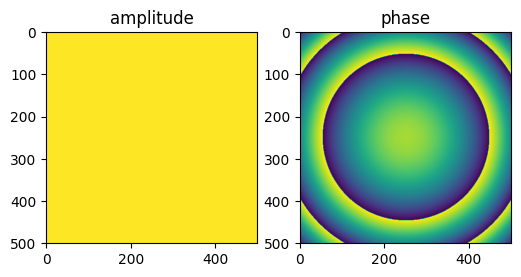

In [2]:
settings = {
    "in_size": [501, 501],
    "in_dx_m": [350e-9, 350e-9],
    "wavelength_set_m": [550e-9],
    "depth_set_m": [1e-2],
    "fshift_set_m": [[0.0, 0.0]],
    "out_distance_m": 1e-2,
    "aperture_radius_m": None,
    "radial_symmetry": False
    }

amp, phase, aperture = focusing_lens(**settings)
print(amp.shape, phase.shape, aperture.shape)

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(amp[0,0]*aperture[0,0], vmin=0, vmax=1)
ax[0].set_title("amplitude")
ax[1].imshow(phase[0,0])
ax[1].set_title("phase")

In [3]:
model_config_path = "metasurface/ckpt/Nanocylinders_TiO2_U180H600_Medium/config.yaml"
amp_ = amp[None]
phase_ = phase[None]
p_norm, p = reverse_lookup_optimize(
    amp_,
    phase_,
    [550e-9],
    model_config_path,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=500,)

Target Module: dflat.metasurface.optical_model.NeuralCells
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint /home/deanhazineh/Research/Dflat-pytorch-private_version2/dflat/metasurface/ckpt/Nanocylinders_TiO2_U180H600_Medium/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


Target Module: dflat.metasurface.optical_model.NeuralCells
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint /home/deanhazineh/Research/Dflat-pytorch-private_version2/dflat/metasurface/ckpt/Nanocylinders_TiO2_U180H600_Medium/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


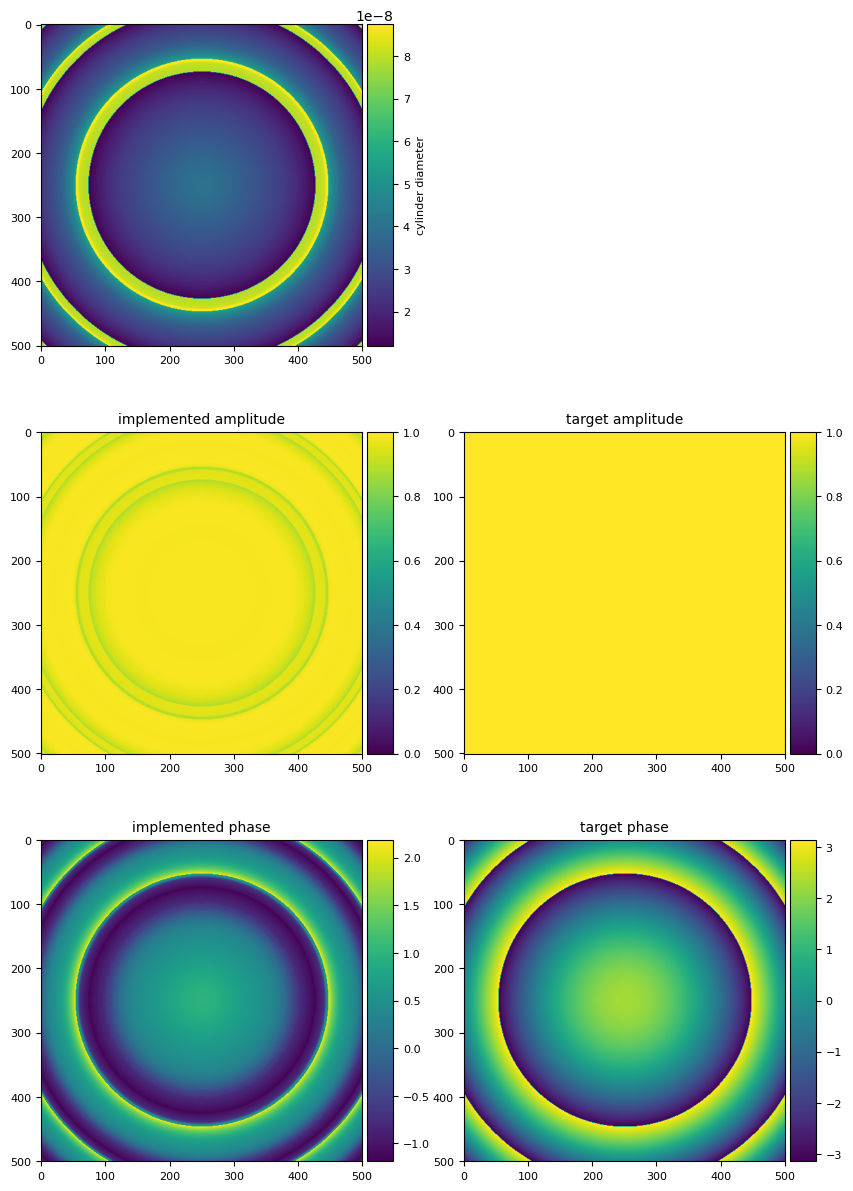

In [4]:
model = load_optical_model(model_config_path)
model = model.to("cuda")
est_amp, est_phase = model(p, np.array([550e-9]), pre_normalized=False)

fig, ax = plt.subplots(3,2, figsize=(10,15))
ax[0,0].imshow(p.squeeze())
mp_format.formatPlot(fig, ax[0,0], addcolorbar=True, setAspect="equal", cbartitle="cylinder diameter")
ax[0,1].axis('off')

ax[1,0].imshow(est_amp.squeeze().cpu().numpy(), vmin=0, vmax=1)
mp_format.formatPlot(fig, ax[1,0], title="implemented amplitude", addcolorbar=True, setAspect="equal")
ax[1,1].imshow(amp.squeeze(), vmin=0, vmax=1)
mp_format.formatPlot(fig, ax[1,1], title="target amplitude",  addcolorbar=True, setAspect="equal")


ax[2,0].imshow(est_phase.squeeze().cpu().numpy())
mp_format.formatPlot(fig, ax[2,0], title="implemented phase", addcolorbar=True, setAspect="equal")
ax[2,1].imshow(phase.squeeze())
mp_format.formatPlot(fig, ax[2,1], title="target phase", addcolorbar=True, setAspect="equal")

In [5]:
print(est_amp.shape, est_phase.shape)

PSF = PointSpreadFunction(
    in_size=[501, 501],
    in_dx_m=[350e-9, 350e-9],
    out_distance_m=1e-2,
    out_size=[512, 512],
    out_dx_m=[1e-6,1e-6],
    out_resample_dx_m=None,
    radial_symmetry=False,
    diffraction_engine="ASM")

ps_locs = [[0.0, 0.0, 1e-3], [0.0, 0.0, 1e-2], [0.0, 0.0, 5e-2]]
intensity, phase = PSF(est_amp, est_phase, [500e-9, 550e-9, 600e-9], ps_locs, aperture=None, normalize_to_aperture=True)
print(intensity.shape, phase.shape)

torch.Size([1, 1, 1, 501, 501]) torch.Size([1, 1, 1, 501, 501])
torch.Size([1, 1, 501, 501]) torch.Size([1, 1, 501, 501])
torch.Size([1, 1, 3, 3, 512, 512]) torch.Size([1, 1, 3, 3, 512, 512])


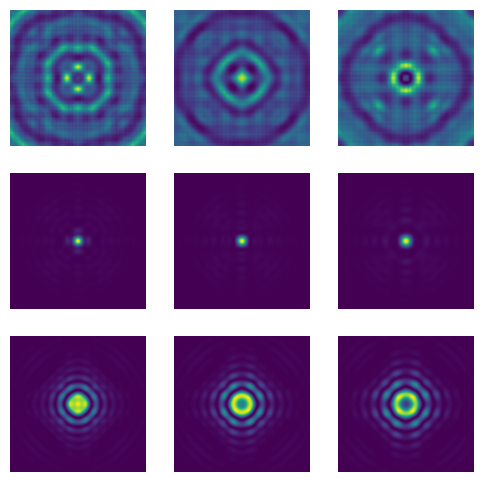

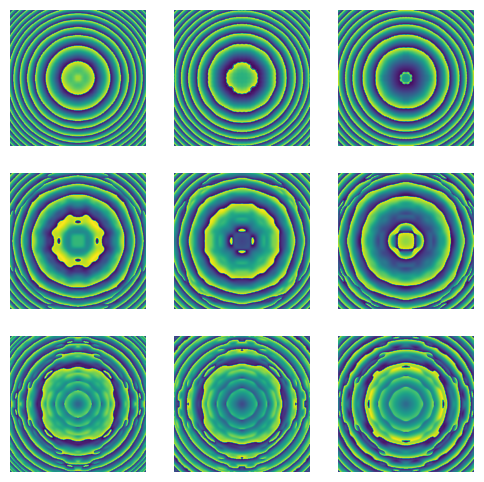

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(6,6))
for z in range(3):
    for l in range(3):
        ax[z,l].imshow(intensity[0,0, z, l,:,:].cpu().numpy())
        ax[z,l].axis('off')

fig, ax = plt.subplots(3, 3, figsize=(6,6))
for z in range(3):
    for l in range(3):
        ax[z,l].imshow(phase[0,0, z, l,:,:].cpu().numpy())
        ax[z,l].axis('off')

